[View in Colaboratory](https://colab.research.google.com/github/AnujArora23/FlightDelayML/blob/master/SGDFlightDelayDataset.ipynb)

# Flight Delay Prediction (Regression)

These datasets are taken from Microsoft Azure Machine Learning Studio's sample datasets. It contains flight delay data for various airlines for the year 2013. There are two files uploaded as a compressed archive on my GitHub page:

1) **Flight_Delays_Data.csv** : This contains arrival and departure details for various flights operated by 16 different airlines. The schema is pretty self explanatory but I will mention the important and slightly obscure columns:

*OriginAirportID/DestAirportID* : The unique 5 digit integer identifier for a particular airport.

*CRSDepTime/CRSArrTime* : Time in 24 hour format (e.g. 837 is 08:37AM)

*ArrDel15/DepDel15* : Binary columns where *1* means that the flight was delayed beyond 15 minutes and *0* means it was not.

*ArrDelay/DepDelay* : Time (in minutes) by which flight was delayed.


2) **Airport_Codes_Dataset.csv** : This file gives the city, state and name of the airport along with the unique 5 digit integer identifier.

### Goals:


**1.  Clean the data, and see which features may be important and which might be redundant.**

**2. Do an exploratory analysis of the data to identify where most of the flight delays lie (e.g. which carrier, airport etc.).**

**3.  Choose and build an appropriate regression model for this dataset to predict *ArrDelay* time in minutes.**

**4. Choose and build alternative models and compare all models with various accuracy metrics.**



## Install and import necessary libraries

In [0]:
!pip install -U -q PyDrive #Only if you are loading your data from Google Drive

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn import grid_search
from sklearn import metrics

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Authorize Google Drive (if your data is stored in Drive)

In [3]:
%%capture
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&prompt=select_account&response_type=code&client_id=32555940559.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline

Enter verification code: ··········


## Data Ingestion

I have saved the two files in my personal drive storage and read them from there into a pandas data frame. Please modify the following cells to read the CSV files into a Pandas dataframe as per your storage location.

In [0]:
%%capture
downloaded = drive.CreateFile({'id':'1VxxZFZO7copAM_AHHF42zjO7rlGR1aPm'}) # replace the id with id of file you want to access
downloaded.GetContentFile('Airport_Codes_Dataset.csv')  
downloaded = drive.CreateFile({'id':'1owzv86uWVRace_8xvRShFrDTRXSljp3I'}) # replace the id with id of file you want to access
downloaded.GetContentFile('Flight_Delays_Data.csv') 
airpcode = pd.read_csv('Airport_Codes_Dataset.csv') 
flightdel = pd.read_csv('Flight_Delays_Data.csv') 

## Data Cleanup

### Remove NULL /NaN rows and drop redundant columns

In [0]:
flightdel.dropna(inplace=True) #Drop NaNs. We will still have enough data
flightdel.drop(['Year','Cancelled'],axis=1,inplace=True) #There is only 1 unique value for both (2013 and 0 respectively)
flightdel.reset_index(drop=True,inplace=True)

###Join the 2 CSV files to get airport code details for origin and destination

In [0]:
result=pd.merge(flightdel,airpcode,left_on='OriginAirportID',right_on='airport_id',how='left')
result.drop(['airport_id'],axis=1,inplace=True)
#result.reset_index(drop=True,inplace=True)
result.rename(columns={'city':'cityor','state':'stateor','name':'nameor'},inplace=True)
result=pd.merge(result,airpcode,left_on='DestAirportID',right_on='airport_id',how='left')
result.drop(['airport_id'],axis=1,inplace=True)
result.reset_index(drop=True,inplace=True)
result.rename(columns={'city':'citydest','state':'statedest','name':'namedest'},inplace=True)
flightdelfin=result

### Perform Feature Conversion (to categorical dtype)

In [0]:
cols=['Carrier','DepDel15','ArrDel15','OriginAirportID','DestAirportID','cityor','stateor','nameor','citydest','statedest','namedest']
flightdelfin[cols]=flightdelfin[cols].apply(lambda x: x.astype('category'))     

###Drop duplicate observations

In [0]:
flightdelfin.drop_duplicates(keep='first',inplace=True)
flightdelfin.reset_index(drop=True,inplace=True)

###Drop columns that are unnecessary for analysis

**In particular, we drop ArrDel15 and DepDel15 columns as they add no extra information from the ArrDel and DepDel columns respectively.**

In [9]:
flightdelan=flightdelfin.iloc[:,0:11]
flightdelan.drop('DepDel15',axis=1,inplace=True)
flightdelan.head()

,Month,DayofMonth,DayOfWeek,Carrier,OriginAirportID,DestAirportID,CRSDepTime,DepDelay,CRSArrTime,ArrDelay
0,4,19,5,DL,11433,13303,837,-3.0,1138,1.0
1,4,19,5,DL,14869,12478,1705,0.0,2336,-8.0
2,4,19,5,DL,14057,14869,600,-4.0,851,-15.0
3,4,19,5,DL,15016,11433,1630,28.0,1903,24.0
4,4,19,5,DL,11193,12892,1615,-6.0,1805,-11.0


###Final check before analysis

** We check if our data types are correct and do a general scan of the dataframe information. It looks good! Everything is as it should be.**

In [10]:
flightdelan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2690385 entries, 0 to 2690384
Data columns (total 10 columns):
Month              int64
DayofMonth         int64
DayOfWeek          int64
Carrier            category
OriginAirportID    category
DestAirportID      category
CRSDepTime         int64
DepDelay           float64
CRSArrTime         int64
ArrDelay           float64
dtypes: category(3), float64(2), int64(5)
memory usage: 151.4 MB


In [0]:
#flightdelan[['Month','DayofMonth','DayOfWeek']]=flightdelan[['Month','DayofMonth','DayOfWeek']].apply(lambda x: x.astype(np.int64))

## Data Exploration

### Number of flights per carrier in 2013

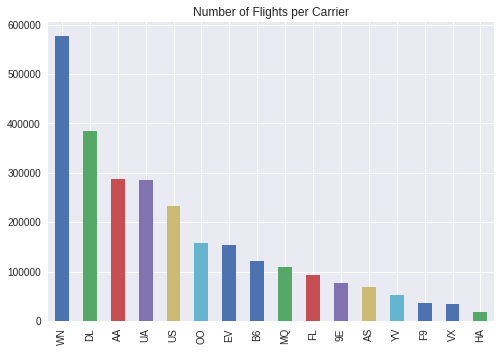

In [12]:
#fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k'); #Use this for a larger size image
bp=flightdelan.Carrier.value_counts(sort=True, ascending=False).plot(kind='bar',title='Number of Flights per Carrier')
plt.show()

**As we can see above the highest number of flights are operated by WN i.e. *Southwest Airlines*, followed by (not closely) DL i.e. *Delta Airlines*, whereas the third highest number of flights are by AA i.e. *American Airlines* which is almost similar to those of UA i.e. *United Airlines.***

### Calculate the average arrival delay (minutes) for all the flights of each carrier

In [13]:
meanarrdel=flightdelan.groupby('Carrier',as_index=False)['ArrDelay'].mean().sort_values('ArrDelay',ascending=False)
meanarrdel.reset_index(drop=True,inplace=True)
meanarrdel.columns=['Carrier','MeanArrDelay']
meanarrdel

,Carrier,MeanArrDelay
0,MQ,14.189485
1,F9,12.834484
2,EV,10.457492
3,B6,9.618305
4,VX,9.613899
5,YV,8.699438
6,WN,8.273722
7,FL,7.226208
8,AA,7.120170
9,OO,6.367287


###Scale and compare the number of flights and average arrival delay

In [0]:
min_max_scaler = preprocessing.MinMaxScaler()
meanarrdel[['MeanArrDelay']]=min_max_scaler.fit_transform(meanarrdel[['MeanArrDelay']])
flightno=pd.DataFrame(flightdelan.Carrier.value_counts(sort=True, ascending=False))
flightno.rename(columns={'Carrier':'NoofFlights'},inplace=True)

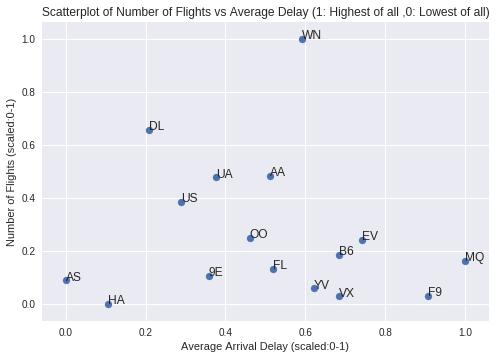

In [15]:
mergedscat=pd.merge(left=meanarrdel,right=flightno,right_index=True,left_on='Carrier',how='left')
mergedscat.columns=['Carrier','AverageArrDelay','Noofflights']
mergedscat[['Noofflights']]=min_max_scaler.fit_transform(mergedscat[['Noofflights']])
fig, ax = plt.subplots()
#fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k');
scat=ax.scatter(mergedscat.AverageArrDelay, mergedscat.Noofflights)

for i, txt in enumerate(mergedscat.Carrier):
    ax.annotate(txt, (mergedscat.AverageArrDelay[i],mergedscat.Noofflights[i]))
    
plt.xlabel('Average Arrival Delay (scaled:0-1)')
plt.ylabel('Number of Flights (scaled:0-1)')
plt.title('Scatterplot of Number of Flights vs Average Delay (1: Highest of all ,0: Lowest of all)')
plt.show()

**As we can see above, the carriers that have a large number of flights (WN,DL,AA) have fared well as they have relatively normal delays. However, even with a low number of flights F9 i.e. *Frontier Airlines* and MQ i.e. *Envoy Air* have the highest delays in the year. **

**This points to some serious planning issues among these smaller airlines or maybe they are more easily affected by outliers, just because they have a lesser number of flights.**

### Boxplots of arrival delays (mins) by carrier.

**Carriers are ordered by the number of flights, decreasing from left to right.**

/usr/local/lib/python2.7/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


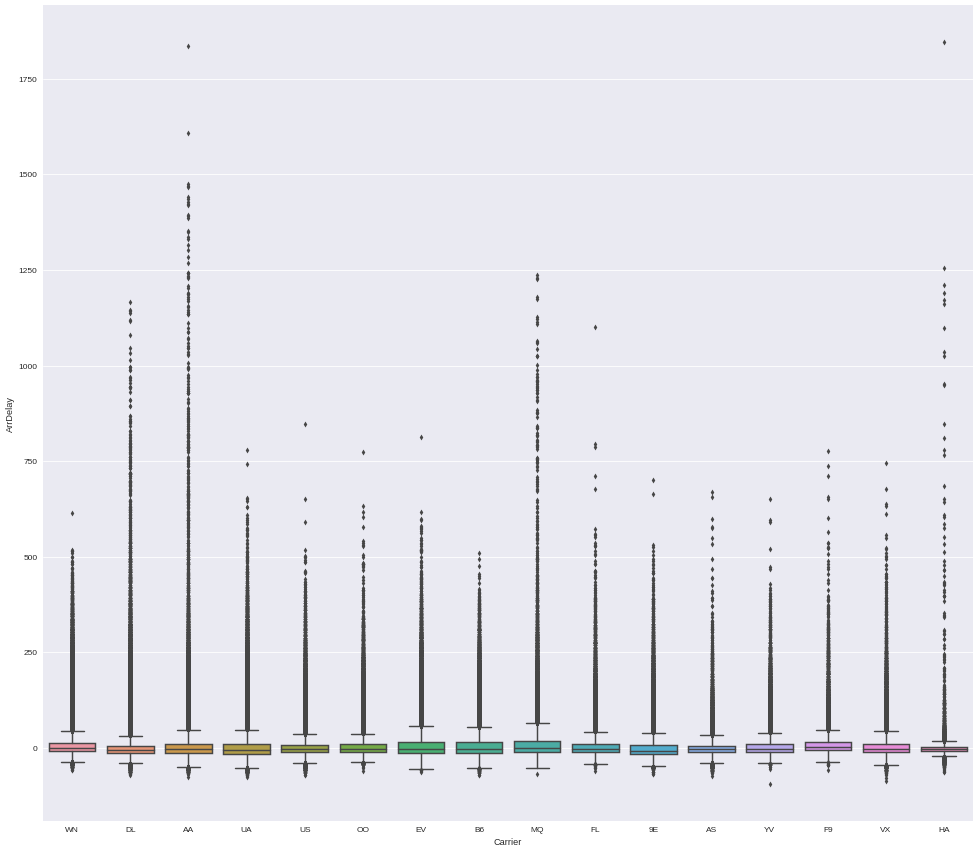

In [16]:
fig=plt.figure(figsize=(20, 18), dpi= 60, facecolor='w', edgecolor='k');
box=sns.boxplot(x="Carrier", y="ArrDelay", data=flightdelan,order=flightno.index)
plt.show()

**As you can see above, the number of outliers are huge and some of them (AA and HA) have had flight delays beyond 1500 minutes (25 hours). That is insane!**

**Also, B6 i.e. *Jetblue Airways* has the least range of outliers but their on time performance is, by no means, excellent. This would mean that they do not have inordinately long delays usually, but  have small delays frequently.**

**For the scale of operations of MQ i.e. *Envoy Air*  and HA i.e. *Hawaiian Airlines*, they should not have such a wide range of outliers. Given that they have a significantly low number of flights relatively (HA has the least!), they should be able to manage their operations better.**



###Percentage of flights delayed beyond 2 hours by carrier (relative to total number of flights)

In [17]:
del2hr=pd.DataFrame(flightdelan[flightdelan.ArrDelay>120].groupby('Carrier').count().sort_values('ArrDelay',ascending=False)['ArrDelay'])
del2hr=del2hr.merge(flightno,left_index=True,right_index=True,how='inner')
del2hr['Delayperc']=((del2hr.ArrDelay.values.astype(np.float)/del2hr.NoofFlights.values)*100)
del2hr.rename(columns={'ArrDelay':'Count'})
del2hr.sort_values('Delayperc',ascending=False)

,ArrDelay,NoofFlights,Delayperc
VX,1334,34794,3.833994
EV,5792,153808,3.765734
MQ,3930,109307,3.595378
B6,4070,121736,3.343300
YV,1449,51803,2.797135
9E,2112,77911,2.710785
UA,7528,285207,2.639486
F9,886,35761,2.477559
AA,6956,288118,2.414289
FL,1895,92393,2.051021


**As we can see, the top airlines with flights delayed beyond 2 hours are VX i.e. *Virgin America* (3.8%), EV i.e. *ExpressJet AIrlines* (3.7%) and MQ i.e. *Envoy Air* (3.6%)**

**Whereas, the airlines with the least amount of flights delayed beyond 2 hours are AS i.e. *Alaska Airlines* (0.6%) and HA i.e. *Hawaiian Airlines* (0.5%).** 

###Busiest routes of 2013

**We can see the busiest routes of 2013 below, in terms of flight frequency.**

In [18]:
citypairfreq=pd.DataFrame(flightdelan.groupby(['OriginAirportID','DestAirportID'])['ArrDelay'].count().sort_values(ascending=False))
citypairfreq.rename(columns = {'ArrDelay':'Flight_Frequency'},inplace=True)
avgcitydel=pd.DataFrame(flightdelan.groupby(['OriginAirportID','DestAirportID'])['ArrDelay'].mean())
avgcitydel.rename(columns = {'ArrDelay':'Avg_ArrivalDel'},inplace=True)
pairdel=citypairfreq.join(avgcitydel,how='inner').sort_values('Flight_Frequency',ascending=False)
pairdel.head()

,,Flight_Frequency,Avg_ArrivalDel
OriginAirportID,DestAirportID,,
14771,12892,9367,11.640333
12892,14771,9306,18.240920
13830,12173,6891,6.337542
12892,12889,6861,6.558811
12173,13830,6856,5.477392


**We are now going to see which city pairs these are by referring the original table. **

**As can be seen below, the first place belongs to: San Franciso - Los Angeles and the second place is simply the reverse route.**

In [19]:
flightdelfin[(flightdelfin.OriginAirportID==14771)&(flightdelfin.DestAirportID==12892)].head(3)

,Month,DayofMonth,DayOfWeek,Carrier,OriginAirportID,DestAirportID,CRSDepTime,DepDelay,DepDel15,CRSArrTime,ArrDelay,ArrDel15,cityor,stateor,nameor,citydest,statedest,namedest
86438,4,2,2,AA,14771,12892,700,-2.0,0.0,830,-17.0,0.0,San Francisco,CA,San Francisco International,Los Angeles,CA,Los Angeles International
86439,4,3,3,AA,14771,12892,700,-5.0,0.0,830,-14.0,0.0,San Francisco,CA,San Francisco International,Los Angeles,CA,Los Angeles International
86440,4,4,4,AA,14771,12892,700,-1.0,0.0,830,-8.0,0.0,San Francisco,CA,San Francisco International,Los Angeles,CA,Los Angeles International


**The second city pair (third after SFO-LA and LA-SFO) that is the most frequent is Kahului to Honolulu.**

In [20]:
flightdelfin[(flightdelfin.OriginAirportID==13830)&(flightdelfin.DestAirportID==12173)].head(3)

,Month,DayofMonth,DayOfWeek,Carrier,OriginAirportID,DestAirportID,CRSDepTime,DepDelay,DepDel15,CRSArrTime,ArrDelay,ArrDel15,cityor,stateor,nameor,citydest,statedest,namedest
66082,4,1,1,HA,13830,12173,609,1.0,0.0,641,7.0,0.0,Kahului,HI,Kahului Airport,Honolulu,HI,Honolulu International
66083,4,2,2,HA,13830,12173,609,-3.0,0.0,641,1.0,0.0,Kahului,HI,Kahului Airport,Honolulu,HI,Honolulu International
66084,4,3,3,HA,13830,12173,609,-8.0,0.0,641,-6.0,0.0,Kahului,HI,Kahului Airport,Honolulu,HI,Honolulu International


## Prediction

### Convert Categorical Variables to Indicator Variables

**To do any sort of prediction, we need to convert the categorical variables to dummy (indicator) variables and drop one group in for each categorical column in the original table, so as to get a baseline to compare to. If we do not drop one group from each categorical variable, our regression will fail due to multicollinearity.**

**The choice of which group(s) to drop is complete arbitrary but in our case, we will drop the carrier with the least number of flights i.e. Hawaiian Airlines (HA), and we will choose an arbitrary city pair with just 1 flight frequency to drop. As of now I have chosen the OriginAirportID as 14771	and the DestAirportID as 13871 to be dropped.**


In [21]:
flightdeldum=pd.get_dummies(flightdelan)
flightdeldum.drop(['Carrier_HA','OriginAirportID_14771','DestAirportID_13871'],axis=1,inplace=True)
flightdeldum.head()

,Month,DayofMonth,DayOfWeek,CRSDepTime,DepDelay,CRSArrTime,ArrDelay,Carrier_9E,Carrier_AA,Carrier_AS,...,DestAirportID_14747,DestAirportID_14771,DestAirportID_14831,DestAirportID_14843,DestAirportID_14869,DestAirportID_14893,DestAirportID_14908,DestAirportID_15016,DestAirportID_15304,DestAirportID_15376
0,4,19,5,837,-3.0,1138,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,19,5,1705,0.0,2336,-8.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,19,5,600,-4.0,851,-15.0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,4,19,5,1630,28.0,1903,24.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,19,5,1615,-6.0,1805,-11.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**As one can see above, each cateogrical column has been converted to 'n' binary columns where n was the number of groups in that particular categorical column.  For example, the carrier column has been split into 16  indicator columns (number of unique carriers) and one has been dropped ('Carrier_HA').**

**Similar logic can be applied to the DestAirportID and OriginAirportID categorical columns.**

**NOTE: The Month, DayofMonth and DayofWeek columns have not been converted to indicator variables because they are ORDINAL cateogorical variables and not nominal. There is a need to retain their ordering because the 2nd month comes after the 1st and so on. Hence, since their current form retains their natural ordering, we do not need to touch these columns.**

### Stochastic Gradient Descent (SGD) Regression

**To predict the arrival delays for various combinations of the input variables and future unseen data, we need to perform a regression since the output variable (ArrDelay) is a continuous one.**

**The choice of an SGD regressor is a logical one as we have hundreds of features, and about 2.7 million observations. The classic multiple linear regression will take too long as the resultant data matrix will be too large to invert. Similar time complexity arguments can be made for simple Gradient Descent as that involves the calculation of the gradient at all observations. Hence, SGD will be suitable and much faster!**

In [0]:
scaler = preprocessing.StandardScaler()
flightdeldum[['CRSDepTime','CRSArrTime','DepDelay']]=scaler.fit_transform(flightdeldum[['CRSDepTime','CRSArrTime','DepDelay']])
y=flightdeldum.ArrDelay
X=flightdeldum.drop('ArrDelay',axis=1)

**In the cell above, we have scaled the relevant columns (Z score) that had values that were dissimilar to the rest of the features, as the regularization strategy we are going to use, requires features to be in a similar range.**

**We now split the data into training and testing data and in this case, we are going to use 80% of the data for training and the remaining for testing.**

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

**We will use elastic net regularization to get the best of both L1 and L2 regularizations. We want feature selection (L1/LASSO) and we want to eliminate any errors due to feature correlations, if any (L2/Ridge).**

In [24]:
reg=SGDRegressor(loss="squared_loss", penalty="elasticnet")
reg.fit(X_train,y_train)

/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=None,
       penalty='elasticnet', power_t=0.25, random_state=None, shuffle=True,
       tol=None, verbose=0, warm_start=False)

**In the above cell, we trained the model using the SGDRegressor and now it is time to predict using the test data.**

In [0]:
y_pred=reg.predict(X_test)

In [26]:
# The coefficients
#print('Coefficients: \n', reg.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test.values, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test.values, y_pred))

Mean squared error: 183.24
Variance score: 0.88


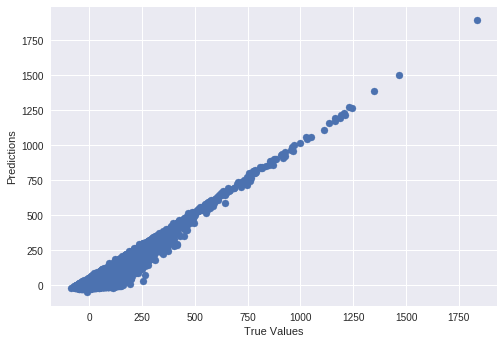

In [27]:
plt.scatter(y_test.values, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.show()

**As we can see from the above cells, 89% of the variance (R^2 score) in the data has been captured and the model is predicting well. The trend line in the graph would be very close to the ideal 45 degree trend line (expected line if the model predicted with 100% accuracy).**

**However, we do not want to overfit our model because we want it to perform well on new untested data. To check if our model overfits, we can run a 6 fold cross validation and analyze the variance (R^2 scores) on each fold ,as shown below:**

In [28]:
# Perform 6-fold cross validation
kfold = KFold(n_splits=6)
scores = cross_val_score(reg, X, y, cv=kfold)
print 'Cross-validated scores:', scores

Cross-validated scores: [0.89341664 0.88913277 0.90557714 0.88741018 0.87579391 0.84723398]


###Grid Search (Hyperparameter Tuning) (Optional and Computationally Expensive)

**The following function performs a search over the entire parameter grid (as specified below) for the initial learning rate, and L1 ratio, and returns the optimal parameters, after an n fold cross validation.**

In [0]:
#https://medium.com/@aneesha/svm-parameter-tuning-in-scikit-learn-using-gridsearchcv-2413c02125a0
def SGD_param_selection(X, y, nfolds):
    eta0s = [0.001, 0.01, 0.1]
    l1_ratios = [0.15, 0.25, 0.35, 0.45, 0.55]
    param_grid = {'eta0': eta0s, 'l1_ratio' : l1_ratios}
    grid_search = GridSearchCV(SGDRegressor(loss="squared_loss", penalty="elasticnet"), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [30]:
SGD_param_selection(X_train,y_train,5)

{'eta0': 0.001, 'l1_ratio': 0.15}

**As we can see above, the grid search has yielded the optimal parameters for the initial learning rate and L1 ratio. This process took about 25 minutes to execute as it is very computationally expensive.**

**Let us now run the SGD with these parameters and check the accuracy.**

In [31]:
reg1=SGDRegressor(loss="squared_loss", penalty="elasticnet",eta0= 0.001,l1_ratio= 0.45)
reg1.fit(X_train,y_train)

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.001,
       fit_intercept=True, l1_ratio=0.45, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=None,
       penalty='elasticnet', power_t=0.25, random_state=None, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [0]:
y_pred1=reg1.predict(X_test)

In [33]:
# The coefficients
#print('Coefficients: \n', reg.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test.values, y_pred1))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test.values, y_pred1))

Mean squared error: 163.81
Variance score: 0.89
